In [1]:
import numpy as np
import math
import scipy
from matplotlib import pyplot as plt
%pylab inline
import matplotlib.pylab as pylab
pylab.rcParams['figure.figsize'] = 10, 10
plt.rc("font", size=23)
from operator import itemgetter

plt.rc('xtick', color='k', labelsize='medium', direction='in')
plt.rc('xtick.major', size=8, pad=12)
plt.rc('xtick.minor', size=8, pad=12)

plt.rc('ytick', color='k', labelsize='medium', direction='in')
plt.rc('ytick.major', size=8, pad=12)
plt.rc('ytick.minor', size=8, pad=12)

Populating the interactive namespace from numpy and matplotlib


This code is a generalization in Python of the code for barcode (BC) lineage tracking analysis from *Blundell and Levy, Nature 2015*. It considers more models than the two originally written which were either the lineage is neutral or a mutant arises in a neutral background.

As this code was designed for analyzing lineage tracking in changing environments, the monoclonal population hypothesis doesn't hold anymore at the interface of two environments (actually because of standing genetic variation even at the beginning of the first environment this hypothesis doesn't hold). So other models have been added: 
- a non neutral mutant exists already at the beginning of the environment
- a non neutral mutant exists already at the beginning of the environment and another mutant rises in that context.

Also because of high standing genetic variation, longer timescale of adaptation and inhomogeneity in the distribution of BC at the interface of environments, we cannot use the hypothesis of neutrally exponentially declining lineages to calculate the mean population fitness: instead we need to have an a priori on the fitness of certain lineages (remeasured lineages) and then compute the population mean fitness.


$\textbf{An example of the outcome of this analysis on simulated data compared to the true parameters value from the simulation is displayed}$ $\textbf{at the end of this notebook.}$

In [2]:
adresse=''#address where your lineage tracking data is
 
c=1.75 #The noise in the birth death process
N_e=6*10**8 #The effective population size . Here it's the bottleneck size times the passage time 
N_final=3*10**7 #The population size you want to be rescaled to
g=8 #Passage time in generation
adresse_cloneInfo=''#address where your fitness remeasurement data is


For the compile_data to work your lineage tracking data file should be in the following format : BC and count  separated by '\t'. The time is calculated as g generations separating two data points. You should manually change this if it is not the case for your application. 

In [3]:
def compile_data(adresse,N_final,g):
    
    f=open(adresse,'r').read()
    contenu=f.splitlines()
    data_dict=dict()
    tt=list()



    for i in range(0,len(contenu),1):

        splite=contenu[i].split('\t')

        data=[float(splite[j]) for j in range(1,len(splite)-1)]

        data_dict[splite[0]]=data


    ssi=[s for s in data_dict.keys()][0]

    
    to=list()
    for i in range(len(data_dict[ssi])):
        dat=list()
        dat_scaled=list()
        for s in data_dict.keys():
            dat.append(data_dict[s][i])
        ppo=sum(dat)
        print('tot '+str(i)+' is',ppo)
        to.append(ppo)
        for s in data_dict.keys():
            dat_scaled=round(data_dict[s][i]/ppo*N_final)

            data_dict[s][i]=dat_scaled
    tt=np.arange(0,len(data_dict[ssi])*g,g)
    return ssi,tt,data_dict

For the compile_clone_info to work each line should contain a BC and a fitness per cycle separated by '\t'

In [4]:
def compile_clone_info(adresse_cloneInfo,g):
    rem={}
    r=open(adresse_cloneInfo,'r').read()
    contenu=r.splitlines()
    for ligne in contenu[1:]:
        contenu_split=ligne.split('\t')
        rem[contenu_split[0]]=float(contenu_split[1])/g#changing fitness per cycle to fitness per generation
    return rem

In [ ]:
[ssi,tt,data_dict]=compile_data(adresse,N_final,g) #ssi: one of the barcode, tt: time series (you might need to manually
# change that to take into account missing time points), data_dict: dictionnary linking a barcode to its time series




In [6]:
rem=compile_clone_info(adresse_cloneInfo,g) #Fitness remeasurement dictionnary already converted in fitness per generation



In [ ]:
zoom=[[data_dict[s][-1],s] for s in data_dict.keys()]
sortt=sorted(zoom,key=itemgetter(0),reverse=True)
list_ordered=[sortt[i][1] for i in range(len(sortt))]#ordering the BC according to their frequency in the population 
#at the last time point : this way we can focus on a subset of barcode that have probably been selected since they are 
#in the top most representated at the end of the environment.

tot_pop=[]

for i in range(len(data_dict[ssi])):
    tot_pop.append(sum([data_dict[s][i] for s in data_dict.keys()]))
print('this is new pop size',tot_pop)

generation=[tt[i+1]-tt[i] for i in range(len(tt)-1)]#retrieving passage time between two time points

timepoint=np.arange(len(data_dict[ssi]))

R_t=tot_pop

All the conditional probability functions that go through ML have the same form as describe in *Blundell and Levy, Nature 2015*, they just use rescaled parameters to broaden what kind of model this conditional probability function can offer.

In [8]:
#Conditional probability for max likelihood to determine mean fitness
def low_abundance_conditional_probability(x,r_t,totit,totitT,r_tT,T,s):
    s_bar=x[0]
    kappa=x[1]
    result=[]
    for i in range(len(r_t)):
        result.append(np.log(np.sqrt((float(r_t[i]*totitT[i])/totit[i]*np.exp(T[i]*(s[i]-s_bar)))**(1./2)/\
                                       (4*math.pi*kappa*(float(r_tT[i])**(3./2))))\
        *np.exp(-((np.sqrt(float(r_tT[i]))-np.sqrt(float(r_t[i]*totitT[i])/totit[i]*np.exp(T[i]*(s[i]-s_bar))))**2)/kappa)))
    return -sum(result)
#Bounded Nelder_Mead algorithm for minimizing the minus likelihood function : you can probably find one already 
#coded in scipy but I had difficulties to make the scipy one worked with bounds so I recoded it.
def Nelder_Mead3(func,arguments,alpha,rho,gamma,sigma,bounds,delta,maxiter):
    dimension=len(arguments[0])+1
    
    dimensions=100*len(arguments[0])
    np.random.seed()
    
    simplex=list()
    constant_arg=[arguments[i] for i in range(1,len(arguments))]
    funquie=list()
    for k in range(dimensions):
        waiting=list()
        for p in range(len(arguments[0])):
            waiting.append(np.random.uniform(bounds[p][0],bounds[p][1]))
        args=[waiting]+constant_arg
        plouf=func(*args)
        simplex.append([waiting,plouf])
        funquie.append(plouf)
        
    when_to_stop=False
    iter_count=0
    
    while when_to_stop==False:
        simplex=sorted(simplex,key=itemgetter(1))
        m=[np.mean([simplex[i][0][j] for i in range(dimension)]) for j in range(dimension-1)]
        r=[m[i]+alpha*(m[i]-simplex[dimension-1][0][i]) for i in range(dimension-1)]
        args=[simplex[dimension-1][0]]+constant_arg
        plus=func(*args)
        args=[simplex[0][0]]+constant_arg
        minus=func(*args)
        args=[r]+constant_arg
        ok_bounds=0
        for i in range(dimension-1):
            if r[i]>=bounds[i][0] and r[i]<=bounds[i][1]:
                ok_bounds=0
            else:
                ok_bounds=1
                break
        if ok_bounds==0:
            middle=func(*args)
        else:
            middle=10**9
        
        
        if middle>minus and middle<plus:
            simplex[dimension-1]=[r,middle]
        else:
            if minus>middle:
                e=[r[i]+gamma*(r[i]-m[i]) for i in range(dimension-1)]
                args=[e]+constant_arg
                ok_bounds=0
                for i in range(dimension-1):
                    if e[i]>=bounds[i][0] and e[i]<=bounds[i][1]:
                        ok_bounds=0
                    else:
                        ok_bounds=1
                        break
                if ok_bounds==0:
                    func_e=func(*args)
                else:
                    func_e=10**9
                if func_e<middle:
                    simplex[dimension-1]=[e,func_e]
                else:
                    simplex[dimension-1]=[r,middle]
            else:
                b=True
                args=[simplex[dimension-2][0]]+constant_arg
                func_n_1=func(*args)
                if middle>=func_n_1:
                    c=[rho*r[i]+(1-rho)*m[i] for i in range(dimension-1)]
                    args=[c]+constant_arg
                    ok_bounds=0
                    for i in range(dimension-1):
                        if c[i]>=bounds[i][0] and c[i]<=bounds[i][1]:
                            ok_bounds=0
                        else:
                            ok_bounds=1
                            break
                    if ok_bounds==0:
                        func_c=func(*args)
                    else:
                        func_c=10**9
                    
                    #func_c=func(*args)
                    if func_c<=middle:
                        simplex[dimension-1]=[c,func_c]
                        b=False
                if b==True:
                    simplex2=[simplex[q] for q in range(len(simplex))]
                    for i in range(1,dimension):
                        simplex2[i][0]=[simplex[0][0][j]+sigma*(simplex[i][0][j]-simplex[0][0][j]) for j in range(dimension-1)] 
                        args=[simplex2[i][0]]+constant_arg
                        simplex2[i][1]=func(*args)
                    simplex=simplex2
        iter_count+=1
        if iter_count==maxiter:
            when_to_stop=True
            #print('Maxiter')
        if abs(simplex[0][1]-simplex[dimension-1][1])<delta:
            when_to_stop=True
            
    return simplex[0]

In [ ]:
remeasured=data_dict.keys()&rem.keys()
rem_neutral=[s for s in remeasured if abs(rem[s])<0.005] # taking only the lineages that have a neutral remeasured fitness
print('total remeasured',len(data_dict.keys()&rem.keys()),'neutral remeasured',len(rem_neutral))

In [10]:
boundaries_mean=[[-0.1,0.2],[1,100]] # Boundaries for the mean fitness and kappa(experimental noise)
thre_pop_mean=100 # One more constrain on which of the neutral lineage you want to do the fit on, here those lineages 
# should be at least 100 in size

In [ ]:
#plotting the lineages that will be used
for s in rem_neutral:
    if min(data_dict[s])>thre_pop_mean:
        plt.plot(tt,data_dict[s])
plt.yscale('log')
plt.xscale('Generations')
plt.yscale('Log10 rescaled lineage size')
plt.show()

In [12]:
#Code for actually proceeding to the maximization of the loglikelihood for esimation of the population mean fitness
def mean_fitness_known_lineages(thre_pop_mean,boundaries_mean,mim,generation):    
    mean_kappa_k=[]
    mean_fitness_k=[]
    for i in range(1,len(data_dict[ssi])):
        arg1=[data_dict[s][i-1] for s in mim if  data_dict[s][i-1]>thre_pop_mean and data_dict[s][i]>thre_pop_mean]
        arg2=[tot_pop[i-1] for s in mim if  data_dict[s][i-1]>thre_pop_mean and data_dict[s][i]>thre_pop_mean]
        arg3=[tot_pop[i] for s in mim if  data_dict[s][i-1]>thre_pop_mean and data_dict[s][i]>thre_pop_mean]
        arg4=[data_dict[s][i] for s in mim if  data_dict[s][i-1]>thre_pop_mean and data_dict[s][i]>thre_pop_mean]
        arg5=[generation[i-1] for s in mim if data_dict[s][i-1]>thre_pop_mean and data_dict[s][i]>thre_pop_mean]
        arg6=[rem[s] for s in mim if data_dict[s][i-1]>thre_pop_mean and data_dict[s][i]>thre_pop_mean]
        print('Number of lineages to fit for time point '+str(i-1)+' is',len(arg6))
        argumentes=[[0,0],arg1,arg2,arg3,arg4,arg5,arg6]
        momo=[]
        for j in range(3):
            [estimate,fval]=Nelder_Mead3(low_abundance_conditional_probability,argumentes,1,0.5,2,0.5,boundaries_mean,10**-6,1000)   

            if -fval>-100000:
                momo.append([estimate,fval])
        [estimate,fval]=sorted(momo,key=itemgetter(1))[0]
        mean_kappa_k.append(estimate[1]) 
        mean_fitness_k.append(estimate[0])
        print('population mean fitness and kappa at time point '+str(i-1)+' are',estimate,'Log-Likelihood is',-fval)
        print()
        
        
        
    provi=mean_fitness_k
    
    mean_fitness_k=provi+[2*provi[len(provi)-1]-provi[len(provi)-2] +0.5*((provi[len(provi)-1]-provi[len(provi)-2])-(provi[len(provi)-2]-provi[len(provi)-3]))]        
    #here we calculate the last bit of mean fitness using first and second derivative 

    smooth_fitness_k=list()
    smooth=mean_fitness_k[0]
    for i in range(len(mean_fitness_k)-1):
        slopes=(mean_fitness_k[i+1]-mean_fitness_k[i])/generation[i]
        for j in range(int(generation[i])):
            smooth+=+slopes
            smooth_fitness_k.append(smooth)
        smooth=mean_fitness_k[i+1]

    smooth_fitness_cut_k=list()
    ploof=0
    for i in range(len(generation)):
        gallile=list()
        for j in range(int(generation[i])):
            gallile.append(smooth_fitness_k[ploof+j])

        ploof+=int(generation[i])
        smooth_fitness_cut_k.append(gallile)


    boodoo=0
    for i in range(len(smooth_fitness_cut_k)):
        boodoo+=len(smooth_fitness_cut_k[i])



    pylab.rcParams['figure.figsize'] = 5, 5
    plt.rc("font", size=23)

    
    x=np.linspace(0,generation[0]*len(generation),generation[0]*len(generation))

    plt.plot(tt,mean_fitness_k,\
             'bo',markersize=20)

    plt.plot(x,smooth_fitness_k,\
             'y',linewidth=5)
    plt.xlabel('Generations')
    plt.ylabel('Estimated population \n mean fitness')

    plt.show()
    
    return mean_kappa_k,mean_fitness_k,smooth_fitness_cut_k,smooth_fitness_k


In [ ]:
[mean_kappa_k,mean_fitness_k,smooth_fitness_cut_k,smooth_fitness_k]=\
mean_fitness_known_lineages(thre_pop_mean,boundaries_mean,rem_neutral,generation)



In [14]:
#taking the known lineage option for mean fitness calculation
mean_kappa=mean_kappa_k
mean_fitness=mean_fitness_k
smooth_fitness=smooth_fitness_k
smooth_fitness_cut=smooth_fitness_cut_k

# Models definition

In [15]:
#The core set of functions that calculate the ML for different model
s_0=smooth_fitness[0]

stop=0
def neutral_hypothesis_probability1(r_t,totit,totitT,r_tT,smoothie,kappa,s1,x):
    
    ending=int(sum([generation[i] for i in range(x)]))
    zumo=int(generation[x])
    
    T_s_bar=sum([s1-smoothie[i] for i in range(ending+zumo)])
    
    result=np.log(np.sqrt((float(r_t*totitT)/totit*np.exp(T_s_bar))**(1./2)/\
                                       (4*math.pi*kappa*(float(r_tT)**(3./2)))))\
    -((np.sqrt(float(r_tT))-np.sqrt(float(r_t*totitT)/totit*np.exp(T_s_bar)))**2)/kappa
    #print(result)
    return result

def log_likelihood_neutral_hypothesis1(data,s1):
    aa=list()
    for i in range(len(timepoint)-1-stop):
        
        aa.append(neutral_hypothesis_probability1(data[0],tot_pop[0],tot_pop[i+1],data[i+1],smooth_fitness,mean_kappa[i],s1,i))
    
    aa.append(np.log(np.sqrt((data[0])**(1./2)/(4*math.pi*2*(data[0])**(3./2))))\
                         -(np.sqrt(data[0])-np.sqrt(data[0]))**2/2)
    log_like=sum(aa)
    
    return log_like

        
        
def adaptive_hypothesis_probability1(key,r_t,r_tT,smoothie,x,kappa,s,s1,tau,Rt,ouft,ouftT):
    
    
    found=False
    
    ending=int(sum([generation[i] for i in range(x)]))
    if tau<=0:
        found=True
        tau_int=int(tau)
        za=0
    
    
    if tau>0 and tau<ending:
        found=True
        tau_int=int(tau)
        za=int(tau/generation[0])
    zumo=int(generation[x])
    
    if found==True:
        
        s_anc=0
        s_mut=s
        cc=c
        if tau_int>=0:
            N=data_dict[key][za]/tot_pop[za]*N_e*np.exp(sum([s1-smoothie[i] for i in range(za*generation[0],tau_int)]))
        else:
            N=data_dict[key][za]/tot_pop[za]*N_e
    
        delta=1
        x_f=[cc/(s_mut-s_anc)*1./N]
        s_bar=[x_f[0]*(s_mut-s_anc)+s_anc]
        for i in range (1,ending+zumo-tau_int):
            x_f.append(x_f[i-1]*np.exp((s_mut-s_bar[i-1])*delta))
            s_bar.append(x_f[i]*(s_mut-s_anc)+s_anc)    
        
        T_s=sum([s for i in range(ending-tau_int,ending+zumo-tau_int)])
        T_s0=sum([s1-smoothie[i] for i in range(ending,ending+zumo)])
        
        if tau_int>=0:
            T_s_0=sum([s_bar[i]+s1-smoothie[i+tau_int] for i in range(ending-tau_int)])
            
        else:
            T_s_0=sum([s_bar[i-tau_int]+s1-smoothie[i] for i in range(ending)]+[s_bar[i]+s1-smoothie[0] for i in range(0,-tau_int)])
            
        New_tot=N*Rt*np.exp(T_s_0)/(N_e)
        x_f[ending-tau_int]*=New_tot
        
        mean_r_tT=((x_f[ending-tau_int])*np.exp(T_s)+\
                       (New_tot-x_f[ending-tau_int]))*np.exp(T_s0)
        
        result=np.log(np.sqrt((mean_r_tT*ouftT/ouft)**(1./2)/(4*math.pi*kappa*(r_tT)**(3./2))))\
            -(np.sqrt(r_tT)-np.sqrt(mean_r_tT*ouftT/ouft))**2/kappa
        
            
    else:
        
        result=neutral_hypothesis_probability1(data_dict[key][0],tot_pop[0],ouftT,r_tT,smooth_fitness,kappa,s1,x)
        
    return result







def log_likelihood_adaptive_hypothesis1(key,data,s,s1,tau):
    
                
    log_like=sum([adaptive_hypothesis_probability1(key,data[i],data[i+1],smooth_fitness,i,mean_kappa[i],\
                                                         s,s1,tau,R_t[i],tot_pop[i],tot_pop[i+1])for i in range(len(timepoint)-1-stop)\
                 ])
    
    
    
    if tau<0 :
    
        s_anc=0
        s_mut=s
        cc=c
        N=data_dict[key][0]/tot_pop[0]*N_e
        
        delta=1
        x_f=[cc/(s_mut-s_anc)*1./N]
        s_bar=[x_f[0]*(s_mut-s_anc)+s_anc]
        for i in range (1,int(abs(tau))):
            x_f.append(x_f[i-1]*np.exp((s_mut-s_bar[i-1])*delta))
            s_bar.append(x_f[i]*(s_mut-s_anc)+s_anc)
        
        T_s=(s)*abs(tau)
        T_s0=(s1-s_0)*abs(tau)
        if (x_f[-1:][0])<=1:
            mean_r_tT=((x_f[-1:][0])*data[0]*np.exp(T_s)+(data[0]-((1-x_f[-1:][0])*data[0])))*np.exp(T_s0)
        else:
            mean_r_tT=((x_f[-1:][0])*data[0]*np.exp(T_s))*np.exp(T_s0)
        
    else:
        mean_r_tT=data[0]
        
        
    log_like+=np.log(np.sqrt((mean_r_tT)**(1./2)\
                                 /(4*math.pi*2*(data[0])**(3./2))))\
                                -(np.sqrt(data[0])-np.sqrt(mean_r_tT))**2/2#-np.log(np.sqrt(data[0]*math.pi*2))
    
    return log_like

In [16]:
zoom=[[data_dict[s][-1],s] for s in data_dict.keys() if min(data_dict[s])>10] # take only lineages with enought read

sortt=sorted(zoom,key=itemgetter(0),reverse=True) #order them in terms of their size at the end of measurement

list_ordered=[sortt[i][1] for i in range(len(sortt))]

mean_exp=0.1 #mean of the prior for the exponential DFE

mut_rate=10**-5

delta_s=0.01 

In [17]:
from scipy import optimize
vr101=list_ordered[:5000] # Fit only the top 5000 lineages at the end of the experiment
vr111=vr101
#model name stands for the variable parameter: 010 means only ancestral mutant is estimated, 101 means that
#rising mutant fitness and establishement time is being estimated, and 111 means all of the above are estimated together
def model010(x,key,data):
    
    s1=x
    
    
    return -(np.log(1./mean_exp*np.exp(-1./mean_exp*s1)*0.001)+log_likelihood_neutral_hypothesis1(data,s1))#-log_likelihood_neutral_hypothesis1(data,s1))



def model101(x,key,data):
    s=x[0]
    w=x[1]
    tau=x[2]
    return -(np.log(1./mean_exp*np.exp(-1./mean_exp*s)*mut_rate*delta_s)+\
    log_likelihood_adaptive_hypothesis1(key,data,s,0,tau))

     


def model111(x,key,data):
    s=x[0]
    s1=x[1]
    tau=x[2]
    
    return -(np.log(1./mean_exp*np.exp(-1./mean_exp*(1*s))*1./mean_exp*np.exp(-1./mean_exp*(s1))*mut_rate*delta_s**2)+log_likelihood_adaptive_hypothesis1(key,data,s,s1,tau))#-log_likelihood_neutral_hypothesis1(data,s1))


In [18]:
def model101_err(x,key,data):
    s=x[0]
    tau=x[1]
    return -(np.log(1./mean_exp*np.exp(-1./mean_exp*s)*mut_rate*delta_s)+\
    log_likelihood_adaptive_hypothesis1(key,data,s,0,tau))


In [19]:
#Estimation of the second derivative around a point of interest
#this hessian is used for an estimation of the Fisher information and so it gives an estimation of the
#interval of confidence for each of our estimated parameters (Within the Guassian assumption of our Max likelihhod landscape)
def hessian(x,dx):
    hessian=np.zeros((len(x),len(x)),dtype='f')
    for i in range(len(hessian)):
        for j in range(len(hessian)):
            hessian[i][j]=((x[i][2]-x[j][1])-(x[i][1]-x[j][0]))/(dx[i]*dx[j])
    return hessian

# Maximum likelihood

Performs ML for 3 different models: output is a text file where a line starting with > gives the different estimators for the different models and the log likelihood associated. 
Everything is separated by '\t'.
So on the same line starting with > it goes like:
- BC
- estimators for one parameter model (0,s1,0) and the log likelihood
- then estimators for the two parameters model (s,0,tau) and the log likelihood
- finally estimators for the three parameters model (s,s1,tau) and the log likelihood.
=> so it is one string and 12 numbers per line starting with >
On the same line starting with @ you will find the standard deviation on those estimators: 
- BC
- 0,std s1,0
- std s,0,std tau
- std s,std s1,std tau
=> so it is one string and 9 numbers per line starting with @

Also, the fitness of the rising mutant is always relative to the ancestral mutant: to have the fitness of the second mutant relative to the neutral lineage, you should add the rising mutant fitness to its ancestral fitness.


In [ ]:

it=len(data_dict[ssi])
fitness_estimate010={}
fitness_estimate010_err={}

rranges =(slice(-0.1,0.2,0.001),)#range of fitness for one parameter model

fitness_estimate101={}
fitness_estimate101_err={}
rrranges=[[0.01,0.2],[0,0],[-100,170]]#range of fitness and establishment time for two parameters model

fitness_estimate111={}
fitness_estimate111_err={}
rrrranges=[[0.01,0.2],[-0.1,0.2],[-100,170]]#range of fitness s and s1 and establishment time for three parameters model



for s in vr111:
    print(s)
    w=open('','a')#add adress where ML analysis should be saved
    argumentes=[[0],s,data_dict[s]]
    #here since the dimension of the likelihood space is one we can afford using brute force optimization
    [estimate,fval,grid,Jout]=scipy.optimize.brute(model010,rranges,(s,data_dict[s]),finish=None,full_output=True)
    
    fitness_estimate010[s]=[[0,estimate,0],-fval]
    print('fitness010',fitness_estimate010[s])
    rranges_err=(slice(estimate-0.02,estimate+0.02,0.01),)#range for curvature estimation : +/- grid size
    [estimate,fval,grid,Jout]=scipy.optimize.brute(model010,rranges_err,(s,data_dict[s]),finish=None,full_output=True)
    h=np.gradient(np.gradient(Jout,0.01))
    fitness_estimate010_err[s]=[0,np.sqrt(it)/(np.sqrt(h[2])),0]# error is approximated by the 1 over sqrt of the second
    #derivative along the parameter of interest
    print('SD 1 param model',fitness_estimate010_err[s])
    
    ###############################################################
    #model101
    
    argumentes=[[fitness_estimate010[s][0][1],0,0],s,data_dict[s]]
    mouf=[]
    
    for i in range(3):
        [estimate,fval]=Nelder_Mead3(model101,argumentes,1,0.5,2,0.5,rrranges,10**-6,100)
        mouf.append([estimate,fval])
        
    [estimate,fval]=sorted(mouf,key=itemgetter(1))[0]
    fitness_estimate101[s]=[[estimate[0],0,estimate[2]],-fval]
    print('fitness101',fitness_estimate101[s])
    
    Jout=[[model101_err([estimate[0]+i*0.01,estimate[2]],s,data_dict[s]) for i in range(-1,2,1)]\
          ,[model101_err([estimate[0],estimate[2]+i],s,data_dict[s]) for i in range(-1,2,1)]]
    
    fitness_estimate101_err[s]=['nan',0,'nan']
    h=hessian(np.array(Jout),[0.01,1])
    
    try:
        
        h=hessian(np.array(Jout),[0.01,1])
        print('hessian 2',h)
        
        
        err1=h[0][0]
        err2=h[1][1]
        
        fitness_estimate101_err[s]=[1./np.sqrt(err1/it),0,1./np.sqrt(err2/it)]
        print('SD 2 param model',fitness_estimate101_err[s])
    except:
        print('Invalid Hessian')

    ##################################################################
    #model111
    
    argumentes=[[0,fitness_estimate010[s][0][1],0],s,data_dict[s]]
    mouf=[]
    
    for i in range(3):
        [estimate,fval]=Nelder_Mead3(model111,argumentes,1,0.5,2,0.5,rrrranges,10**-6,100)
        mouf.append([estimate,fval])
        
    [estimate,fval]=sorted(mouf,key=itemgetter(1))[0]
    fitness_estimate111[s]=[estimate,-fval]
    print('fitness111',fitness_estimate111[s])
    
    
    
    fitness_estimate111_err[s]=['nan','nan','nan']
    
    try:
        Jout=[[model111([estimate[0]+i*0.01,estimate[1],estimate[2]],s,data_dict[s]) for i in range(-1,2,1)]\
              ,[model111([estimate[0],estimate[1]+i*0.01,estimate[2]],s,data_dict[s]) for i in range(-1,2,1)]\
          ,[model111([estimate[0],estimate[1],estimate[2]+i],s,data_dict[s]) for i in range(-1,2,1)]]
        h=hessian(np.array(Jout),[0.01,0.01,1])#[:,:,1,2]
        
        print('hessian 3',h)
        

        err1=h[0][0]
        err2=h[1][1]
        err3=h[2][2]
        fitness_estimate111_err[s]=[1./np.sqrt(err1/it),1./np.sqrt(err2/it),1./np.sqrt(err3/it)]
        
        print('SD 3 param model',fitness_estimate111_err[s])
        print()
    except:
        print('Invalid Hessian')
    w.write('>'+s+'\t'+str(fitness_estimate010[s][0][0])+'\t'+str(fitness_estimate010[s][0][1])+'\t'+str(fitness_estimate010[s][0][2])+'\t'+str(fitness_estimate010[s][1])\
           +'\t'+str(fitness_estimate101[s][0][0])+'\t'+str(fitness_estimate101[s][0][1])+'\t'+str(fitness_estimate101[s][0][2])+'\t'+str(fitness_estimate101[s][1])\
           +'\t'+str(fitness_estimate111[s][0][0])+'\t'+str(fitness_estimate111[s][0][1])+'\t'+str(fitness_estimate111[s][0][2])+'\t'+str(fitness_estimate111[s][1])+'\n')
    
    w.write('@'+s+'\t'+str(fitness_estimate010_err[s][0])+'\t'+str(fitness_estimate010_err[s][1])+'\t'+str(fitness_estimate010_err[s][2])\
           +'\t'+str(fitness_estimate101_err[s][0])+'\t'+str(fitness_estimate101_err[s][1])+'\t'+str(fitness_estimate101_err[s][2])\
           +'\t'+str(fitness_estimate111_err[s][0])+'\t'+str(fitness_estimate111_err[s][1])+'\t'+str(fitness_estimate111_err[s][2])+'\n')
    w.close()
    print()

In [21]:
#calculating the portion of lineage mean fitness due to rising mutant
def adaptive_hypothesis_probability_mean(key,smoothie,x,s,s1,tau,Rt):
    
    
    found=False
    
    ending=int(sum([generation[i] for i in range(x)]))
    if tau<=0:
        found=True
        tau_int=int(tau)
        za=0
    
    
    if tau>0 and tau<ending:
        found=True
        tau_int=int(tau)
        za=int(tau/generation[0])
    zumo=int(generation[x])
    
    if found==True:
        
        s_anc=0
        s_mut=s
        cc=c
        if tau_int>=0:
            N=data_dict[key][za]/tot_pop[za]*N_e*np.exp(sum([s1-smoothie[i] for i in range(za*generation[0],tau_int)]))
        else:
            N=data_dict[key][za]/tot_pop[za]*N_e
    
        delta=1
        x_f=[cc/(s_mut-s_anc)*1./N]
        s_bar=[x_f[0]*(s_mut-s_anc)+s_anc]
        
        for i in range (1,ending+zumo-tau_int):
            x_f.append(x_f[i-1]*np.exp((s_mut-s_bar[i-1])*delta))
            s_bar.append(x_f[i]*(s_mut-s_anc)+s_anc)  
        T_s=sum([s for i in range(ending-tau_int,ending+zumo-tau_int)])
        T_s0=sum([s1-smoothie[i] for i in range(ending,ending+zumo)])
        
        if tau_int>=0:
            T_s_0=sum([s_bar[i]+s1-smoothie[i+tau_int] for i in range(ending-tau_int)])
            
        else:
            T_s_0=sum([s_bar[i-tau_int]+s1-smoothie[i] for i in range(ending)]+[s_bar[i]+s1-smoothie[0] for i in range(0,-tau_int)])
            
        New_tot=N*Rt*np.exp(T_s_0)/(N_e)
        x_f[ending-tau_int]*=New_tot
        mean_r_tT=x_f[ending-tau_int]*np.exp(T_s)*s/\
                       ((New_tot-x_f[ending-tau_int])*np.exp(T_s0)+x_f[ending-tau_int]*np.exp(T_s))
       
        result=mean_r_tT
        
        
            
    else:
        result=0
    
    return result

# Choosing model

In [ ]:
#choosing model according to number of parameters and rising mutant contribution to lineage mean fitness
mean_lineage_fitness_thre=0.01
from scipy import stats
fitness_estimate={}
fitness_err={}
bi={1:fitness_estimate010,2:fitness_estimate101,3:fitness_estimate111,0:{s:[[0,0,0],0] for s in fitness_estimate101.keys()}}
bi_err={1:fitness_estimate010_err,2:fitness_estimate101_err,3:fitness_estimate111_err,0:{s:[0,0,0] for s in fitness_estimate101.keys()}}

for s in fitness_estimate101.keys():
    miko=sorted([[fitness_estimate010[s][1],1],[fitness_estimate101[s][1],2],[fitness_estimate111[s][1],3],[log_likelihood_neutral_hypothesis1(data_dict[s],0),0]],reverse=True,key=itemgetter(0))
    

    broom=miko[0]
    print('Model ordered by Loglikelihood',miko)
    for i in range(1,3):
        
        if broom[1]-miko[i][1]>0:# just making sure that we are prioritizing lower number of paramters
            
            mucho=1
            
            if broom[1]==3 or broom[1]==2:
                mucho=adaptive_hypothesis_probability_mean(s,smooth_fitness,len(data_dict[s])-2\
                                         ,bi[broom[1]][s][0][0],bi[broom[1]][s][0][1],\
                                         bi[broom[1]][s][0][2],tot_pop[-2])
                
                
                
            if mucho<mean_lineage_fitness_thre :
                
                broom=miko[i]
    print(s)
    
    fitness_estimate[s]=bi[broom[1]][s]
    fitness_err[s]=bi_err[broom[1]][s]
    print('fitness_estimate',fitness_estimate[s])
    print('fitness_err',fitness_err[s])
    print()

When the model is chosen it is saved in a file thanks to the code in the next cell. It follows the same rules as before .

In [26]:
w=open('','w')# add address where the chosen model and the error on estimate should be saved
for s in fitness_estimate.keys():
    w.write('>'+s+'\t'+str(fitness_estimate[s][0][0])+'\t'+str(fitness_estimate[s][0][1])+'\t'+str(fitness_estimate[s][0][2])+'\t'+str(fitness_estimate[s][1])+'\n')
    w.write('@'+s+'\t'+str(fitness_err[s][0])+'\t'+str(fitness_err[s][1])+'\t'+str(fitness_err[s][2])+'\n')
w.close()


# Visualization

In [ ]:
#plots the phase space of your evolution
pylab.rcParams['figure.figsize'] = 5, 5
plt.rc("font", size=23)
word=[s for s in fitness_estimate.keys() if len(fitness_estimate[s][0])==3]

plt.scatter([fitness_estimate[s][0][2] for s in word if fitness_estimate[s][0][1]!=0 and fitness_estimate[s][0][0]!=0 and min(data_dict[s])>0 ],\
            [fitness_estimate[s][0][0]+fitness_estimate[s][0][1] for s in word if fitness_estimate[s][0][1]!=0 and fitness_estimate[s][0][0]!=0 ],c='r',alpha=0.5,label='3 parameters model \n mutants')#here we add the ancestral mutant fitness to the rising mutant as their are relative to each other
plt.scatter([fitness_estimate[s][0][2] for s in word if fitness_estimate[s][0][1]==0 and fitness_estimate[s][0][0]!=0 and min(data_dict[s])>0 ],\
            [fitness_estimate[s][0][0]+fitness_estimate[s][0][1] for s in word if fitness_estimate[s][0][1]==0 and fitness_estimate[s][0][0]!=0 and min(data_dict[s])>0 ],c='g',label='2 parameters model \n mutants')

plt.legend(loc='best',fontsize=10)
plt.tight_layout()
plt.savefig('',bbox_inches='tight')
plt.xlabel('Establishment time (generation)')
plt.ylabel('Fitness per generation')
plt.show()



In [ ]:
#plots the DFE for the selected models
pylab.rcParams['figure.figsize'] = 5, 20
plt.rc("font", size=23)
mi=-0.1
ma=0.1
nnn=np.arange(mi,ma,(ma-mi)/100)
plt.subplot(4,1,1)
print('Fraction of lineages explained by 1 parameter model',len([fitness_estimate[s][0][1] for s in fitness_estimate.keys() if fitness_estimate[s][0][0]==0 and fitness_estimate[s][0][2]==0]\
         )/len(fitness_estimate))
plt.hist(\
    [fitness_estimate[s][0][1] for s in fitness_estimate.keys() if fitness_estimate[s][0][0]==0 and fitness_estimate[s][0][2]==0],color='k',label='1 parameter model',bins=nnn)
plt.subplot(4,1,2)
print('Fraction of lineages explained by 2 parameters model',len([fitness_estimate[s][0][0] for s in fitness_estimate.keys() if fitness_estimate[s][0][1]==0 and fitness_estimate[s][0][2]!=0]\
         )/len(fitness_estimate))
plt.hist(\
    [fitness_estimate[s][0][0] for s in fitness_estimate.keys() if fitness_estimate[s][0][1]==0 and fitness_estimate[s][0][2]!=0],color='g',label='2 parameters model',bins=nnn)
plt.subplot(4,1,3)
print('Fraction of lineages explained by 3 parameters model',len([fitness_estimate[s][0][1]+fitness_estimate[s][0][0] for s in fitness_estimate.keys() if fitness_estimate[s][0][0]!=0 and fitness_estimate[s][0][2]!=0 and fitness_estimate[s][0][1]!=0]\
         )/len(fitness_estimate))
plt.hist(\
    [fitness_estimate[s][0][1]+fitness_estimate[s][0][0] for s in fitness_estimate.keys() if fitness_estimate[s][0][0]!=0 and fitness_estimate[s][0][2]!=0 and fitness_estimate[s][0][1]!=0],color='r',label='3 parameters model : mutant',bins=nnn)
plt.subplot(4,1,4)
plt.hist(\
    [fitness_estimate[s][0][1] for s in fitness_estimate.keys() if fitness_estimate[s][0][0]!=0 and fitness_estimate[s][0][2]!=0 and fitness_estimate[s][0][1]!=0],color='lightcoral',label='3 parameters model : original',bins=nnn)

plt.tight_layout()
plt.savefig('',bbox_inches='tight')
plt.show()

# Initial mix of mutants model : optional

Give you the option to add one more model if you are dissatisfied with too negative establishment time: this model postulate that there is actually already two mutants in the lineage at the beginning of the environment. The model estimates the frequency of those two mutants in the lineage as well as their fitnesses. The fitness of the less abundant mutant is relative to the more abundant one (i.e. the more abundant mutant fitness should be added to the less abundant one). fitness_estimate1111[BC]=(s less abundant, s more abundant, frequency of less abundant).!

In [ ]:
s_0=smooth_fitness[0]

stop=0
def neutral_hypothesis_probability2(r_t,totit,totitT,r_tT,smoothie,kappa,s1,x):
    
    ending=int(sum([generation[i] for i in range(x)]))
    zumo=int(generation[x])
    
    T_s_bar=sum([s1-smoothie[i] for i in range(ending+zumo)])
    
    result=np.log(np.sqrt((float(r_t*totitT)/totit*np.exp(T_s_bar))**(1./2)/\
                                       (4*math.pi*kappa*(float(r_tT)**(3./2)))))\
    -((np.sqrt(float(r_tT))-np.sqrt(float(r_t*totitT)/totit*np.exp(T_s_bar)))**2)/kappa
    
    return result

def log_likelihood_neutral_hypothesis2(data,s1):
    aa=list()
    for i in range(len(timepoint)-1-stop):
        
        aa.append(neutral_hypothesis_probability1(data[0],tot_pop[0],tot_pop[i+1],data[i+1],smooth_fitness,mean_kappa[i],s1,i))
    
    aa.append(np.log(np.sqrt((data[0])**(1./2)/(4*math.pi*2*(data[0])**(3./2))))\
                         -(np.sqrt(data[0])-np.sqrt(data[0]))**2/2)
    log_like=sum(aa)
    
    return log_like

        
        
def adaptive_hypothesis_probability2(key,r_t,r_tT,smoothie,x,kappa,s,s1,tau,Rt,ouft,ouftT):
    
    found=True
    ending=int(sum([generation[i] for i in range(x)]))
    zumo=int(generation[x])
    N=data_dict[key][0]/tot_pop[0]*N_e
    if found==True:
        
        s_anc=0
        s_mut=s
        
        
        
        
            
        delta=1
        x_f=[tau]
        s_bar=[x_f[0]*(s_mut-s_anc)+s_anc]
        for i in range (1,ending+zumo):
            x_f.append(x_f[i-1]*np.exp((s_mut-s_bar[i-1])*delta))
            s_bar.append(x_f[i]*(s_mut-s_anc)+s_anc)    
        
        T_s=sum([s for i in range(ending,ending+zumo)])
        T_s0=sum([s1-smoothie[i] for i in range(ending,ending+zumo)])
        
        if tau>=0:
            T_s_0=sum([s_bar[i]+s1-smoothie[i] for i in range(ending)])
            
        
        New_tot=N*Rt*np.exp(T_s_0)/(N_e)
        x_f[ending]*=New_tot
        
        mean_r_tT=((x_f[ending])*np.exp(T_s)+\
                       (New_tot-x_f[ending]))*np.exp(T_s0)
        
        result=np.log(np.sqrt((mean_r_tT*ouftT/ouft)**(1./2)/(4*math.pi*kappa*(r_tT)**(3./2))))\
            -(np.sqrt(r_tT)-np.sqrt(mean_r_tT*ouftT/ouft))**2/kappa
        
            
    else:
        
        result=neutral_hypothesis_probability1(data_dict[key][0],tot_pop[0],ouftT,r_tT,smooth_fitness,kappa,s1,x)
        
    return result







def log_likelihood_adaptive_hypothesis2(key,data,s,s1,tau):
    
                
    log_like=sum([adaptive_hypothesis_probability2(key,data[i],data[i+1],smooth_fitness,i,mean_kappa[i],\
                                                         s,s1,tau,R_t[i],tot_pop[i],tot_pop[i+1])for i in range(len(timepoint)-1-stop)\
                 ])
    
    
    found=True
    if found==True :
        
        s_anc=0
        s_mut=s
        
        
        
        
        T_s=(s)
        T_s0=(s1-s_0)
        if (tau)<=1:
            mean_r_tT=((tau)*data[0]*np.exp(T_s)+(data[0]-((1-tau)*data[0])))*np.exp(T_s0)
        else:
            mean_r_tT=((tau)*data[0]*np.exp(T_s))*np.exp(T_s0)
        
    else:
        mean_r_tT=data[0]
        
        
    log_like+=np.log(np.sqrt((mean_r_tT)**(1./2)\
                                 /(4*math.pi*2*(data[0])**(3./2))))\
                                -(np.sqrt(data[0])-np.sqrt(mean_r_tT))**2/2#-np.log(np.sqrt(data[0]*math.pi*2))
    
    return log_like

In [ ]:
def model1111(x,key,data):
    s=x[0]
    s1=x[1]
    tau=x[2]
    
    return -(np.log(1./mean_exp*np.exp(-1./mean_exp*(2*s1+s))*mut_rate**2*delta_s**3))
fitness_estimate1111={}
fitness_estimate1111_err={}
ranges=[[0.01,0.2],[-0.1,0.2],[0,0.4]]


for s in vr111:
    
    
    argumentes=[[0,fitness_estimate010[s][0][1],0],s,data_dict[s]]
    mouf=[]
    
    for i in range(3):
        [estimate,fval]=Nelder_Mead3(model1111,argumentes,1,0.5,2,0.5,ranges,10**-6,100)
        mouf.append([estimate,fval])
       
    [estimate,fval]=sorted(mouf,key=itemgetter(1))[0]
    fitness_estimate1111[s]=[estimate,-fval]
    print('Log likelihood',-fval)
    print('Estimates',estimate)
    fitness_estimate1111_err[s]=['nan','nan','nan']
    
    try:
        Jout=[[model1111([estimate[0]+i*0.01,estimate[1],estimate[2]],s,data_dict[s]) for i in range(-1,2,1)]\
              ,[model1111([estimate[0],estimate[1]+i*0.01,estimate[2]],s,data_dict[s]) for i in range(-1,2,1)]\
          ,[model1111([estimate[0],estimate[1],estimate[2]+i*0.01],s,data_dict[s]) for i in range(-1,2,1)]]
        h=hessian(np.array(Jout),[0.01,0.01,0.01])#[:,:,1,2]
        
        print('hessian Mix',h)
        

        err1=h[0][0]
        err2=h[1][1]
        err3=h[2][2]
        fitness_estimate1111_err[s]=[1./np.sqrt(err1/it),1./np.sqrt(err2/it),1./np.sqrt(err3/it)]
        
        print('SD Mix initial model',fitness_estimate1111_err[s])
        print()
    except:
        print('Invalid Hessian')
    
    

# Analysis accuracy : example

In [1]:
from IPython.display import Image

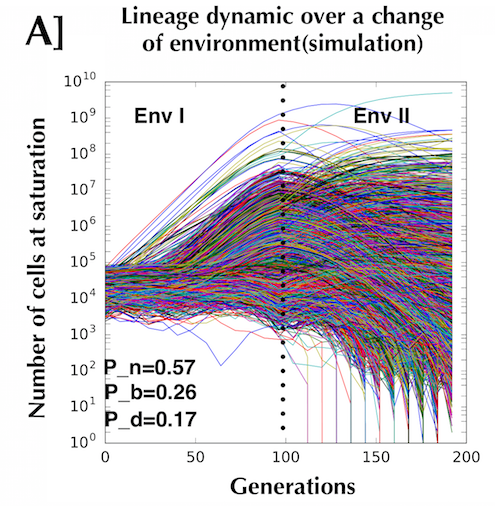

In [2]:
Image(filename='/Users/labguest/Documents/Seb/Portfolio/fig/FigSI18_cropped.png')

$\textbf{Simulation used to check analysis}$

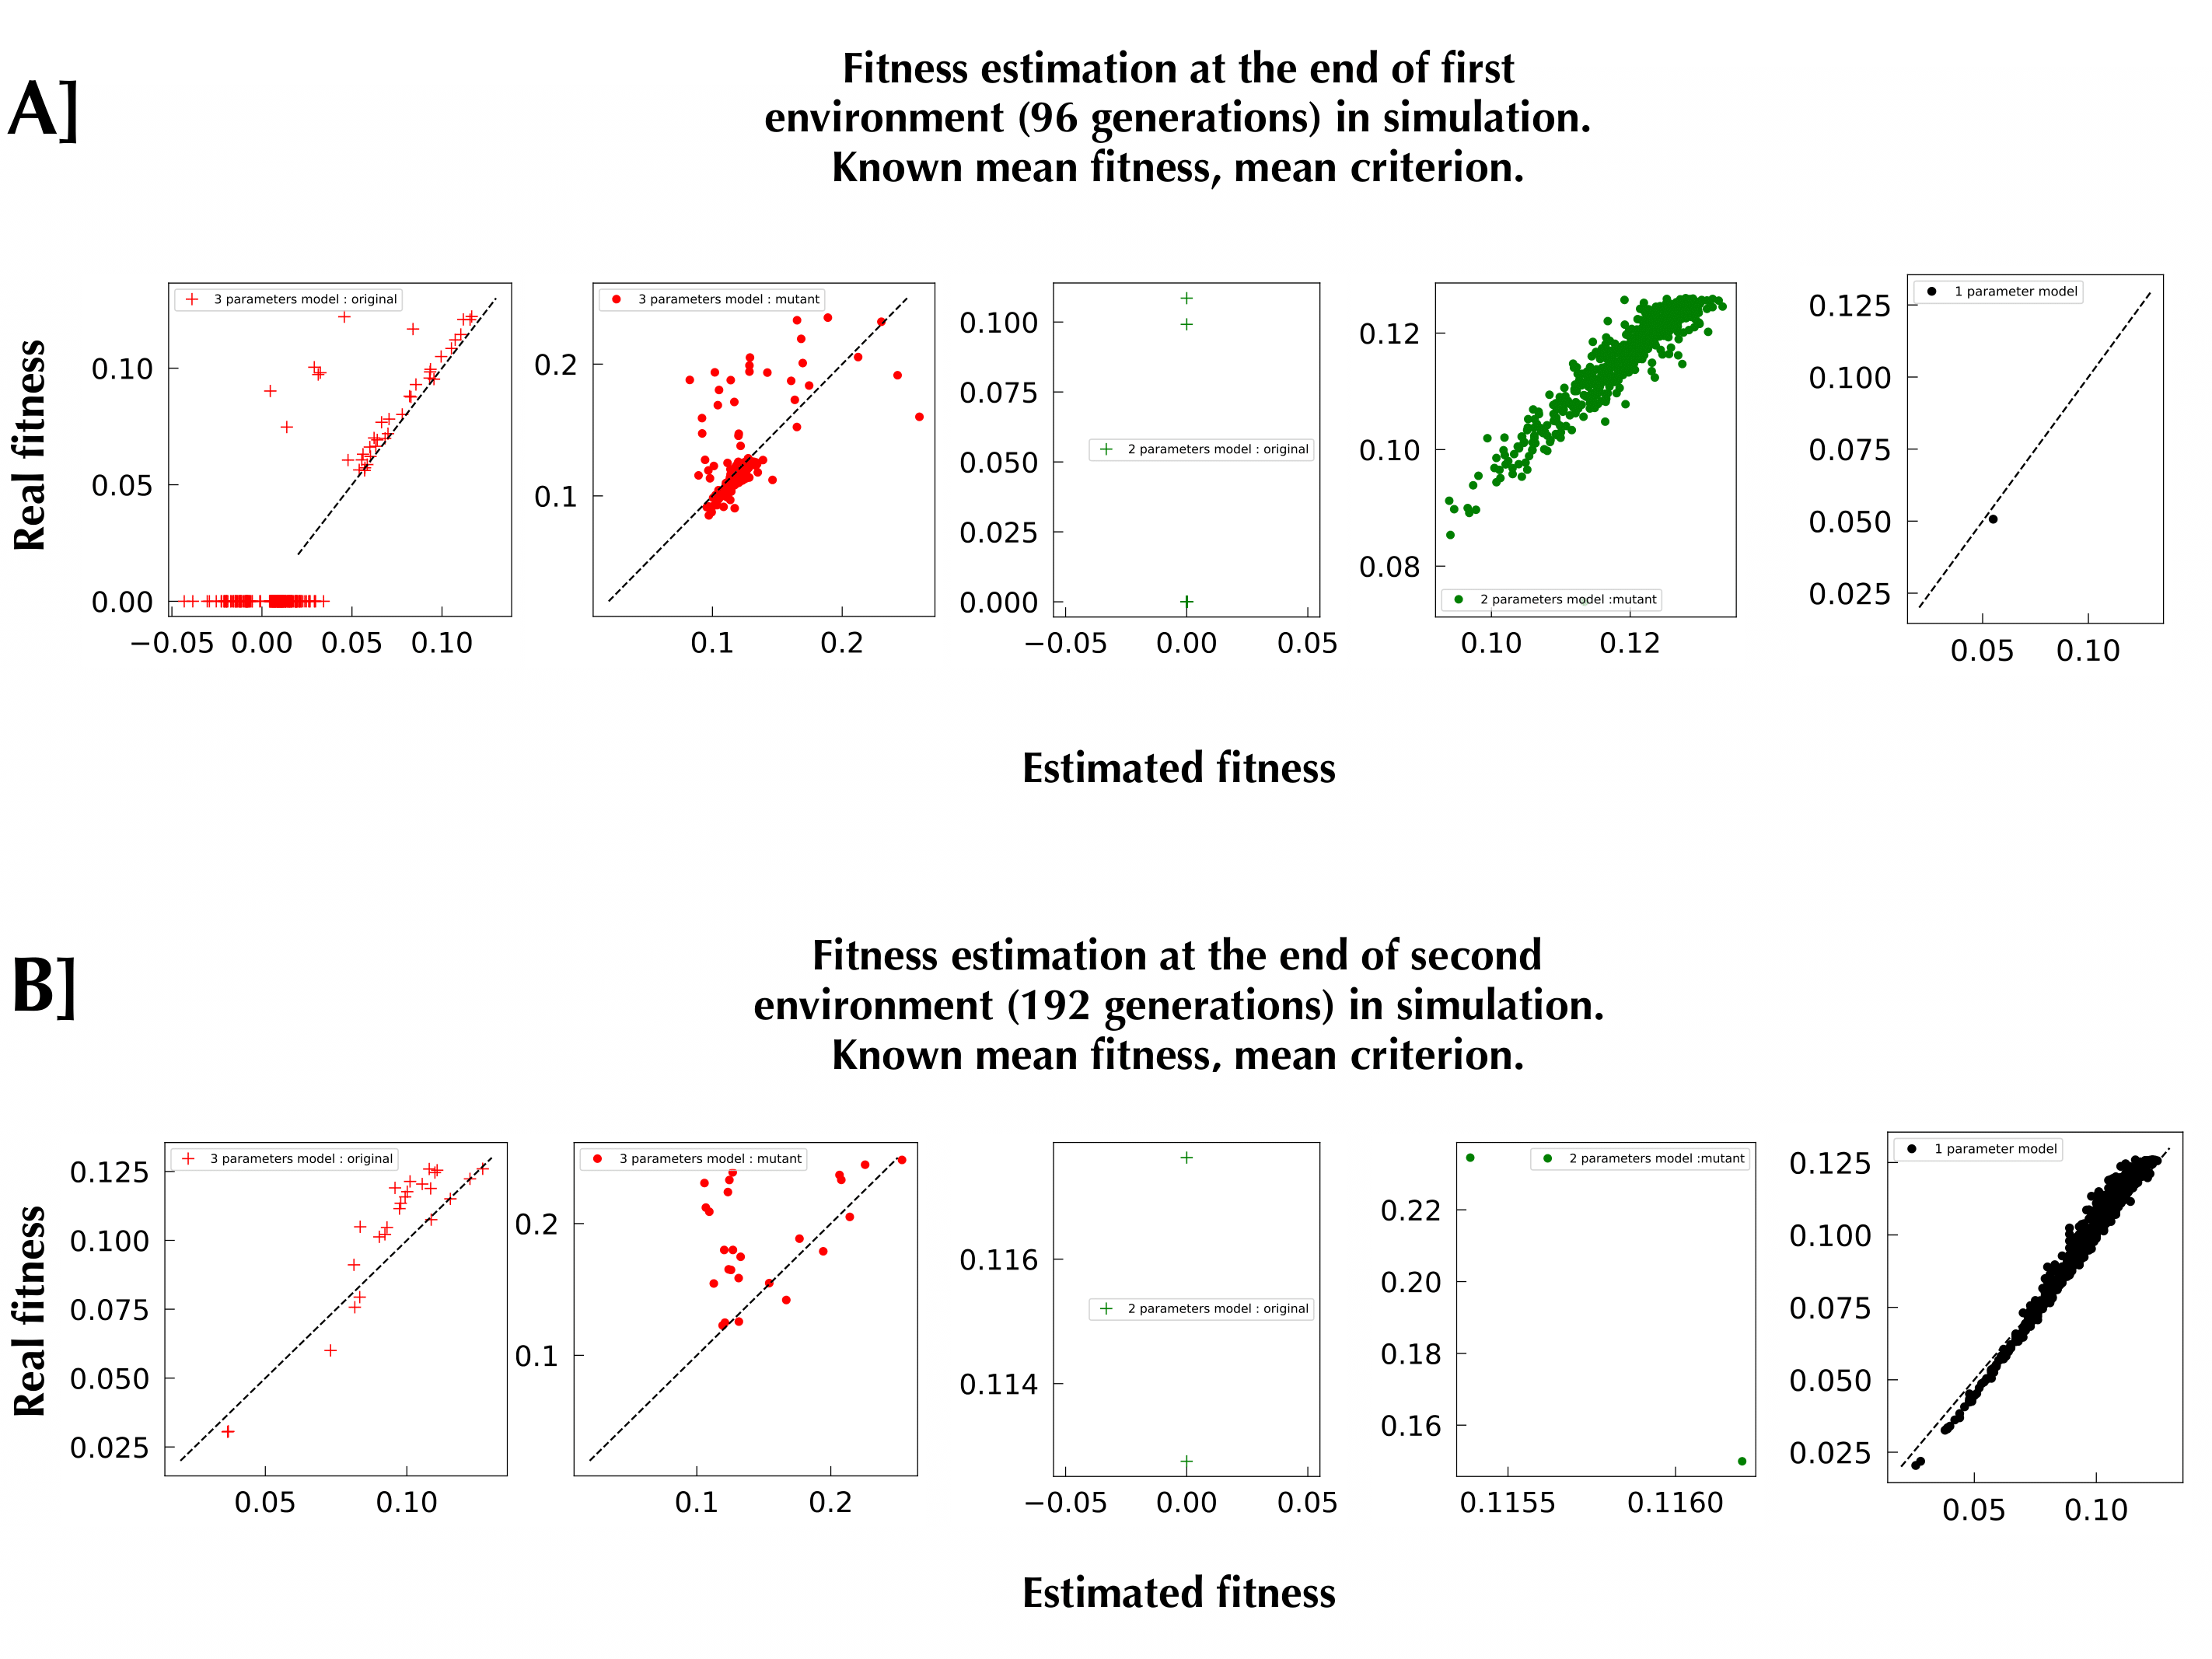

In [3]:
Image(filename='/Users/labguest/Documents/Seb/Portfolio/fig/FigSI23-1.png')

$\textbf{Comparison between estimated fitness from different chosen best model by the code and their real value.}$ Analysis makes good model prediction and good range of value prediction.